<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/chipsff_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


Wait for a few seconds to restart the kernel

Install all necessary packages, including CHIPS-FF (https://github.com/usnistgov/chipsff)

In [1]:
%%time
!conda install chgnet phonopy pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - chgnet
    - phonopy
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       3_kmp_llvm           7 KB  conda-forge
    aom-3.6.1                  |       h59595ed_0         2.6 MB  conda-forge
    ase-3.25.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    bibtexparser-1.4.3         |     pyhd8ed1ab_0          41 KB  conda-forge
    blas-1.0                   |              mkl           1 KB  conda-forge
    blinker-1.9.0              |     pyhff2d567_0          14 KB  conda-forge
    brotli-1.1.0               |       hb9d3cd8_2          19 KB  conda-forge
    brotli-bin-1.1.0      

In [2]:
!conda install ipykernel -q -y
!pip install  -q -U git+https://github.com/usnistgov/chipsff.git@develop
!pip install -q elastic
!pip install "plotly<6" "kaleido<1"

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ipykernel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asttokens-3.0.0            |     pyhd8ed1ab_1          28 KB  conda-forge
    comm-0.2.2                 |     pyhd8ed1ab_1          12 KB  conda-forge
    debugpy-1.8.14             |  py311hfdbb021_0         2.5 MB  conda-forge
    decorator-5.2.1            |     pyhd8ed1ab_0          14 KB  conda-forge
    exceptiongroup-1.3.0       |     pyhd8ed1ab_0          21 KB  conda-forge
    executing-2.2.0            |     pyhd8ed1ab_0          29 KB  conda-forge
    ipykernel-6.29.5           |     pyh3099207_0         116 KB  conda-forge
    ipython-9.4.0              |     pyhfa0c392_0         614 KB  conda-forge
    ipython_pygments_lexers

Run a sample geometry optimization using CHGNet and apply isotropic strain (energy vs. volume).

Let's test Silicon (JVASP-1002) and Gallium Arsenide (JVASP-1174)

In [3]:
!wget https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_optim.json
!run_chipsff --input_file input_optim.json

--2025-07-09 04:26:40--  https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_optim.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327 [text/plain]
Saving to: ‘input_optim.json’

input_optim.json    100%[===================>]     327  --.-KB/s    in 0s      

2025-07-09 04:26:40 (15.3 MB/s) - ‘input_optim.json’ saved [327/327]

{'alignn_ff_db': False,
 'bulk_relaxation_settings': {'filter_type': 'ExpCellFilter',
                              'relaxation_settings': {'constant_volume': False,
                                                      'fmax': 0.05,
                                                      'steps': 200}},
 'calculator_settings': {},
 'calculator_type': None,
 'calculator_types': ['chgn

Let's take a look at the output files that were created (detailed json and log files with MLFF and ground truth DFT, automated error metrics)

In [4]:
!ls JVASP-1174_chgnet/*

JVASP-1174_chgnet/E_vs_V_curve.png
JVASP-1174_chgnet/E_vs_V_data.txt
JVASP-1174_chgnet/JVASP-1174_bulk_relaxed.vasp
JVASP-1174_chgnet/JVASP-1174_chgnet_error_dat.csv
JVASP-1174_chgnet/JVASP-1174_chgnet_error_scorecard.png
JVASP-1174_chgnet/JVASP-1174_chgnet_job_info.json
JVASP-1174_chgnet/JVASP-1174_chgnet_results.json
JVASP-1174_chgnet/JVASP-1174_job_log.txt


Energy vs. Volume Curve (Murnaghan Fit)

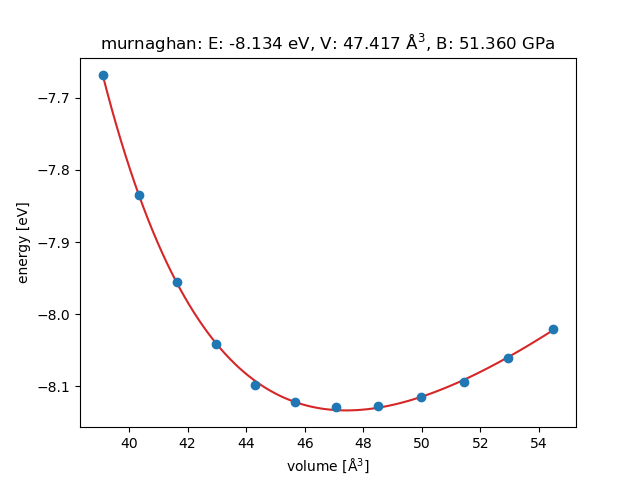

In [5]:
from IPython.display import Image, display
display(Image("JVASP-1174_chgnet/E_vs_V_curve.png", width=800))

Let's create parity plots for lattice constant predictions (with respect to JARVIS-DFT results)

In [ ]:
from jarvis.db.jsonutils import loadjson
import glob
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error

mem = []
ids = []
for filepath in glob.glob("*chgnet/*results.json"):
    d = loadjson(filepath)
    mem.append(d)
    ids.append(filepath.split("_")[0])

df = pd.DataFrame(mem)
df["id"] = ids
df.head()

initial_a = [entry["energy"]["initial_a"] for entry in mem]
initial_b = [entry["energy"]["initial_b"] for entry in mem]
initial_c = [entry["energy"]["initial_c"] for entry in mem]

final_a = [entry["energy"]["final_a"] for entry in mem]
final_b = [entry["energy"]["final_b"] for entry in mem]
final_c = [entry["energy"]["final_c"] for entry in mem]

fig_a = px.scatter(
    x=initial_a,
    y=final_a,
    labels={
        "x": "JARVIS-DFT a (Å)",
        "y": "MLFF a (Å)"
    },
    title="Lattice parameter a: JARVIS-DFT vs MLFF for CHGNet"
)
fig_a.show()

mae_a = mean_absolute_error(initial_a, final_a)
print(f"MAE (a): {mae_a:.3f} Å")


fig_b = px.scatter(
    x=initial_b,
    y=final_b,
    labels={
        "x": "JARVIS-DFT b (Å)",
        "y": "MLFF b (Å)"
    },
    title="Lattice parameter b: JARVIS-DFT vs MLFF for CHGNet"
)
fig_b.show()

mae_b = mean_absolute_error(initial_b, final_b)
print(f"MAE (b): {mae_b:.3f} Å")

fig_c = px.scatter(
    x=initial_c,
    y=final_c,
    labels={
        "x": "JARVIS-DFT c (Å)",
        "y": "MLFF c (Å)"
    },
    title="Lattice parameter c: JARVIS-DFT vs MLFF for CHGNet"
)
fig_c.show()

mae_c = mean_absolute_error(initial_c, final_c)
print(f"MAE (c): {mae_c:.3f} Å")

MAE (a): 0.011 Å


MAE (b): 0.011 Å


MAE (c): 0.011 Å


Let's run an example phonon calculation for Silicon using CHGNet

In [ ]:
!wget https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_phonon.json
!run_chipsff --input_file input_phonon.json

--2025-07-08 18:32:48--  https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_phonon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385 [text/plain]
Saving to: ‘input_phonon.json’

input_phonon.json   100%[===================>]     385  --.-KB/s    in 0s      

2025-07-08 18:32:48 (4.97 MB/s) - ‘input_phonon.json’ saved [385/385]

{'alignn_ff_db': False,
 'bulk_relaxation_settings': {'filter_type': 'ExpCellFilter',
                              'relaxation_settings': {'constant_volume': False,
                                                      'fmax': 0.05,
                                                      'steps': 200}},
 'calculator_settings': {},
 'calculator_type': None,
 'calculator_types': ['c

From here, we can visualize the phonon band structure and thermal properties (free energy, heat capacity, entropy)

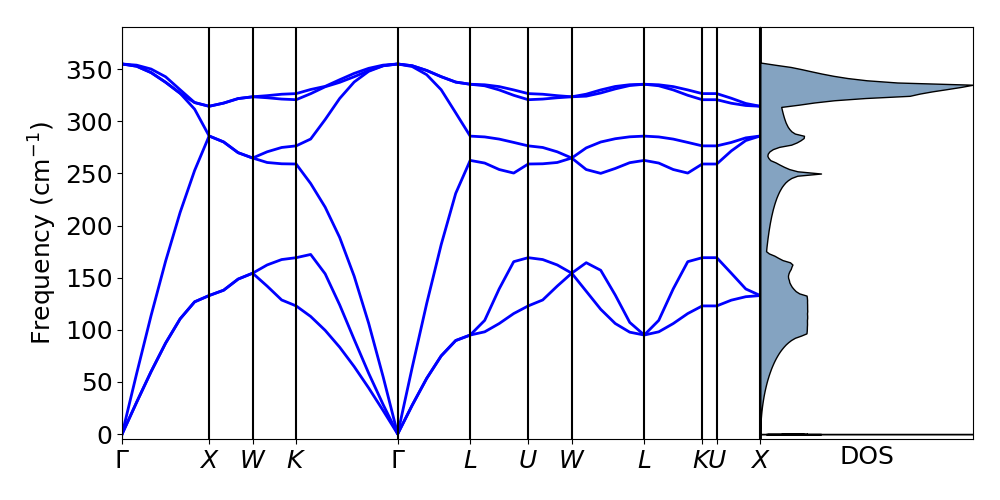

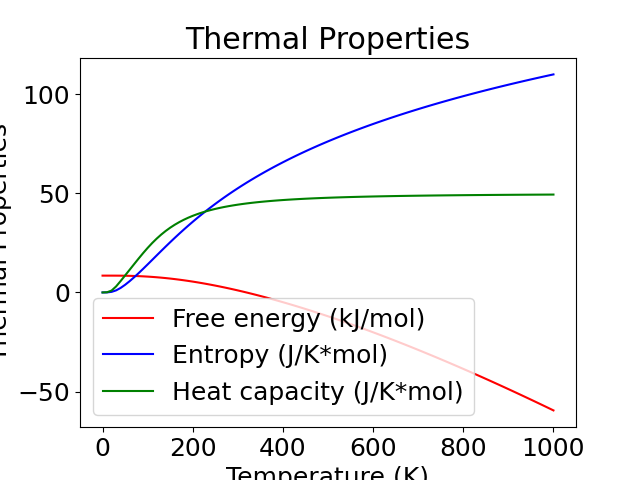

In [ ]:
from IPython.display import Image, display
display(Image("JVASP-1002_chgnet/ph_JVASP-1002_chgnet.png", width=800))
display(Image("JVASP-1002_chgnet/Thermal_Properties_JVASP-1002.png", width=800))

Let's calculate the vacancy formation energy with CHGNet for Si and GaAs

In [ ]:
!wget https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_defect.json
!wget https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/chemical_potentials.json
!run_chipsff --input_file input_defect.json

--2025-07-08 18:35:25--  https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_defect.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 636 [text/plain]
Saving to: ‘input_defect.json’

input_defect.json   100%[===================>]     636  --.-KB/s    in 0s      

2025-07-08 18:35:25 (22.5 MB/s) - ‘input_defect.json’ saved [636/636]

--2025-07-08 18:35:25--  https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/chemical_potentials.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting 

In [ ]:
import glob, json
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error

vac_records = []
for path in glob.glob("*chgnet/*results.json"):
    with open(path) as f:
        data = json.load(f)
    for rec in data.get("vacancy_energy", []):
        vac_records.append(
            {
                "name":   rec["name"],
                "JARVIS": rec["vac_en_entry"],
                "MLFF":   rec["vac_en"],
            }
        )

vac_df = pd.DataFrame(vac_records)

fig_vac = px.scatter(
    vac_df,
    x="JARVIS",
    y="MLFF",
    hover_name="name",
    labels={
        "JARVIS": "JARVIS-DFT vacancy formation energy (eV)",
        "MLFF":   "MLFF vacancy formation energy (eV)",
    },
    title="Vacancy formation energy: MLFF vs JARVIS-DFT for CHGNet",
)
lims = [vac_df[["JARVIS", "MLFF"]].min().min(),
        vac_df[["JARVIS", "MLFF"]].max().max()]
fig_vac.add_shape(type="line", x0=lims[0], y0=lims[0], x1=lims[1], y1=lims[1],
                  line=dict(dash="dash"))
fig_vac.show()

mae_vac = mean_absolute_error(vac_df["JARVIS"], vac_df["MLFF"])
print(f"MAE (vacancy energy): {mae_vac:.3f} eV")

MAE (vacancy energy): 1.357 eV


Let's calculate the surface energy with CHGNet for Si for different crystal orientations [001], [111], [100]

In [ ]:
!wget https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_surface.json
!run_chipsff --input_file input_surface.json

--2025-07-08 18:40:38--  https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_surface.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 637 [text/plain]
Saving to: ‘input_surface.json’

input_surface.json  100%[===================>]     637  --.-KB/s    in 0s      

2025-07-08 18:40:38 (21.3 MB/s) - ‘input_surface.json’ saved [637/637]

{'alignn_ff_db': False,
 'bulk_relaxation_settings': {'filter_type': 'ExpCellFilter',
                              'relaxation_settings': {'constant_volume': False,
                                                      'fmax': 0.05,
                                                      'steps': 200}},
 'calculator_settings': {},
 'calculator_type': None,
 'calculator_types': 

In [ ]:
import glob, json
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error

surf_records = []
for path in glob.glob("*chgnet/*results.json"):
    with open(path) as f:
        data = json.load(f)
    for rec in data.get("surface_energy", []):
        surf_records.append(
            {
                "name":   rec["name"],
                "JARVIS": rec["surf_en_entry"],
                "MLFF":   rec["surf_en"],
            }
        )

surf_df = pd.DataFrame(surf_records)

fig_surf = px.scatter(
    surf_df,
    x="JARVIS",
    y="MLFF",
    hover_name="name",
    labels={
        "JARVIS": "JARVIS-DFT surface energy (J m⁻²)",
        "MLFF":   "MLFF surface energy (J m⁻²)",
    },
    title="Surface energy: MLFF vs JARVIS-DFT for CHGNet",
)
lims = [surf_df[["JARVIS", "MLFF"]].min().min(),
        surf_df[["JARVIS", "MLFF"]].max().max()]
fig_surf.add_shape(type="line", x0=lims[0], y0=lims[0], x1=lims[1], y1=lims[1],
                   line=dict(dash="dash"))
fig_surf.show()

mae_surf = mean_absolute_error(surf_df["JARVIS"], surf_df["MLFF"])
print(f"MAE (surface energy): {mae_surf:.3f} J m⁻²")

MAE (surface energy): 1.105 J m⁻²


We can create amorphous Silicon by running a melt/quench Molecular Dynamics simulation with CHGNet

In [ ]:
!wget https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_md_melt_quench.json
!run_chipsff --input_file input_md_melt_quench.json

--2025-07-08 19:25:33--  https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_md_melt_quench.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482 [text/plain]
Saving to: ‘input_md_melt_quench.json.1’

input_md_melt_quenc 100%[===================>]     482  --.-KB/s    in 0s      

2025-07-08 19:25:33 (19.1 MB/s) - ‘input_md_melt_quench.json.1’ saved [482/482]

{'alignn_ff_db': False,
 'bulk_relaxation_settings': {'filter_type': 'ExpCellFilter',
                              'relaxation_settings': {'constant_volume': False,
                                                      'fmax': 0.05,
                                                      'steps': 200}},
 'calculator_settings': {},
 'calculator_type': No

Plot the radial distribution function (RDF) of amorphous Silicon

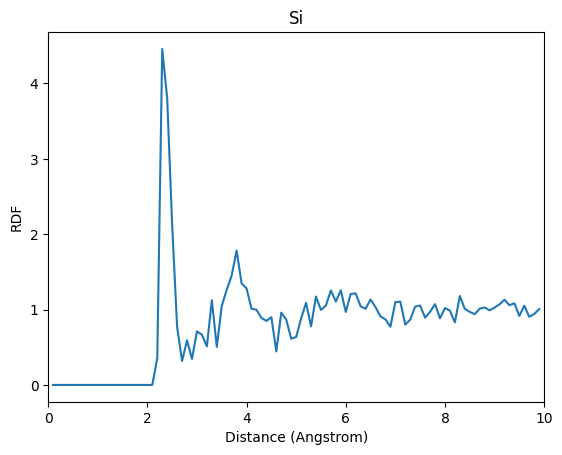

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from jarvis.core.atoms import Atoms
import glob

def get_rdf(atoms=None, ax=None, cutoff=10):
    dists = []
    for i in atoms.get_all_neighbors(r=cutoff):
        for j in i:
            dists.append(j[2])
    dists = np.array(dists)
    hist, bins = np.histogram(dists, bins=np.arange(0.1, cutoff + 0.1, 0.1))
    number_density = atoms.num_atoms / atoms.volume
    shell_vol = (
                4.0
                / 3.0
                * np.pi
                * (np.power(bins[1:], 3) - np.power(bins[:-1], 3))
            )
    rdf = (
                hist / shell_vol / number_density / atoms.num_atoms
            )
    # Plot on the given axis
    ax.plot(bins[:-1], rdf)
    ax.set_xlim([0, cutoff])
    ax.set_xlabel('Distance (Angstrom)')
    ax.set_ylabel('RDF')
    ax.set_title(atoms.composition.reduced_formula)

for i in glob.glob("JVASP-1002_chgnet/POSCAR_JVASP-1002_quenched_chgnet.vasp"):
    fig, ax = plt.subplots()
    atoms = Atoms.from_poscar(i)
    get_rdf(atoms=atoms, ax=ax)
    plt.show()

Example of testing the scaling (system size vs. wall time) of a Cu supercell for CHGNet

In [ ]:
!wget https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_scaling.json
!run_chipsff --input_file input_scaling.json

--2025-07-08 19:33:45--  https://raw.githubusercontent.com/usnistgov/chipsff/refs/heads/develop/chipsff/example_inputs/input_scaling.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123 [text/plain]
Saving to: ‘input_scaling.json’

input_scaling.json  100%[===================>]     123  --.-KB/s    in 0s      

2025-07-08 19:33:45 (1.40 MB/s) - ‘input_scaling.json’ saved [123/123]

{'alignn_ff_db': False,
 'bulk_relaxation_settings': {'filter_type': 'ExpCellFilter',
                              'relaxation_settings': {'constant_volume': False,
                                                      'fmax': 0.05,
                                                      'steps': 200}},
 'calculator_settings': {},
 'calculator_type': None,
 'calculator_types': 

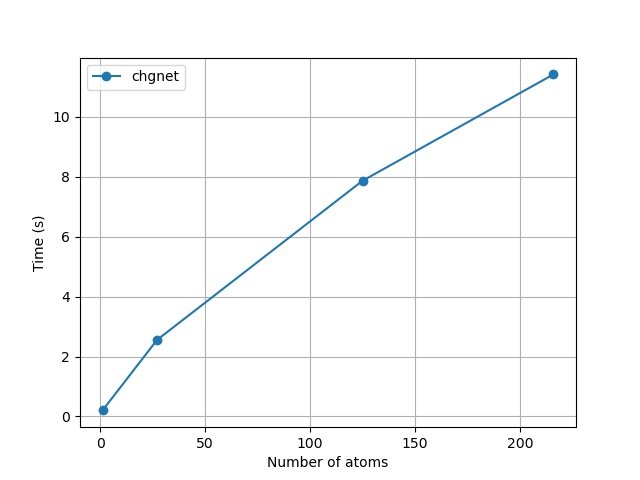

In [ ]:
display(Image("scaling_analysis_Cu/scaling_test.png", width=800))

Excercise: Edit paramters in the input_*.json files and re-run:

 !run_chipsff --input_file input_*.json

 for specific examples